## SCFC Spectral Graph Model Code in Python

In [1]:
import os, matplotlib.pyplot as mpl
import numpy as np
import nitime.algorithms as tsa
from scipy.io import loadmat
from scipy.signal import lfilter, firls, decimate

In [2]:
cwd = os.getcwd()
hcp_dir = os.path.join(cwd,'data','HCPconnectomes')

def getHCPconn(conmat_in = 'mean80_fibercount.csv', dmat_in = 'mean80_fiberlength.csv'):
    cdk_hcp = np.genfromtxt(os.path.join(hcp_dir, conmat_in), delimiter=',', skip_header = 1)
    ddk_hcp = np.genfromtxt(os.path.join(hcp_dir, dmat_in), delimiter = ',', skip_header = 0)
    permHCP = np.concatenate([np.arange(18,52), np.arange(52,86), np.arange(0,9), np.arange(9,18)])
    Cdk_conn = cdk_hcp[permHCP,][:,permHCP]
    Ddk_conn = ddk_hcp[permHCP,][:,permHCP]
    return Cdk_conn, Ddk_conn, permHCP

def Julia_order():
    cortJulia_lh = np.array([0, 1, 2, 3, 4,
                   6, 7, 8,
                   10, 11, 12, 13, 14, 15,
                   17, 16,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                   5, 32, 33, 9])
    qsubcort_lh = np.array([0, 40, 36, 39, 38, 37, 35, 34, 0])
    qsubcort_rh = qsubcort_lh + 34 + 1
    cortJulia = np.concatenate([cortJulia_lh, 34 + cortJulia_lh])
    cortJulia_rh = cortJulia_lh + 34 + 7
    permJulia = np.concatenate([cortJulia_lh, cortJulia_rh, qsubcort_lh, qsubcort_rh])
    emptyJulia = np.array([68, 77, 76, 85])
    return permJulia, emptyJulia, cortJulia

def getMEGdata(sub_name, cortJulia):
    S = loadmat(os.path.join(MEGfolder,sub_name,'DK_timecourse_20.mat'))
    MEGdata = S['DK_timecourse']
    MEGdata = MEGdata[cortJulia,]
    C = loadmat(os.path.join(MEGfolder,sub_name,'DK_coords_meg.mat'))
    coords = C['DK_coords_meg']
    coords = coords[cortJulia,]
    del S, C
    return MEGdata, coords

def mag2db(y):
    dby = 20*np.log10(y)
    return dby

def bi_symmetric_c(Cdk_conn, linds, rinds):
    q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
    q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])
    Cdk_conn[np.ix_(linds,linds)] = q
    Cdk_conn[np.ix_(rinds,rinds)] = q
    Cdk_conn[np.ix_(linds,rinds)] = q1
    Cdk_conn[np.ix_(rinds,linds)] = q1
    return Cdk_conn

def reduce_extreme_dir(Cdk_conn, max_dir = 0.95, f=7):
    thr = f*np.mean(Cdk_conn[Cdk_conn > 0])
    C = np.minimum(Cdk_conn, thr)
    C = max_dir * C + (1-max_dir) * C
    return C

# def getMEGspectra(use_allJuliaMEG = False):
#    if use_allJuliaMEG:
#        S = loadmat(os.path.join(MEGfolder,'allFMEGdata.mat'))
#        FMEGdata = np.mean(S['allFMEGdata'], axis = 2)
#    else:
#        # Calculate spectra from source localized MEG
#        for row in MEGdata:

def NetworkTransferFunction(C, D, w, Pin = 1, tau_e = 0.012, tau_i = 0.003, alpha = 1, tau_syn = 0.002, speed = 5):
    zero_thr = 5
    use_smalleigs = True #otherwise uses full eig()
    numsmalleigs = np.round(2/3*C.shape[0]) #2/3
    
    a = 0.5 # fraction of signal at a node that is recurrent excitatory
    gei = 4 # excitatory-inhibitory synaptic conductance as a ratio of E-E synapse
    gii = 1 # inhibitory-inhibitory synaptic conductance as a ratio of E-E synapse
    
    tauC = 0.5*tau_e
            
    rowdegree = np.transpose(np.sum(C,axis=1))
    coldegree = np.sum(C,axis=0)
    
    qind = rowdegree + coldegree < 0.2*np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    
    nroi = C.shape[0]
    if use_smalleigs is True:
        K = numsmalleigs
    else:
        K = nroi

    K = K.astype(int)
    Tau = 0.001*D/speed
    
    Cc = np.real(C*np.exp(-1j*Tau*w)).astype(float)
    L1 = 0.8*np.identity(nroi).astype(float)
    L2 = np.divide(1,np.sqrt(rowdegree*coldegree)+np.spacing(1)) #diag(1./(sqrt(rowdegree.*coldegree)+eps));
    L = L1 - np.matmul(np.diag(L2),Cc)
    L = np.array(L,dtype=np.float64)

    # try scipy.sparse.linalg.eigs next
    if use_smalleigs is True:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.real(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
    else:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.abs(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
        
    ev = np.transpose(eig_val[0:K.astype(int)])
    Vv = eig_vec[:,0:K.astype(int)] #why is eigv 1 all the same numbers?

    # Cortical model
    He = np.divide(1/tau_e**2,np.real((1j*w+1/tau_e)**2))
    Hi = np.divide(gii*1/tau_i**2,np.real((1j*w+1/tau_i)**2))

    Hed = alpha/tau_e/(1j*w + alpha/tau_e*He)
    Hid = alpha/tau_i/(1j*w + alpha/tau_i*Hi)

    Heid = gei*He*Hi/(1+gei*He*Hi)
    Htotal = a*Hed + (1-a)/2*Hid + (1-a)/2*Heid

    q1 = 1/alpha*tauC*(1j*w + alpha/tauC*He*ev)
    qthr = zero_thr*np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1),qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1,np.exp(1j*angq1))
    freqresp = np.divide(Htotal,q1)

    freqresp_out = 0
    for k in range(1,K):
        freqresp_out += freqresp[k] * Vv[:,k]
    
    FCmodel = np.matmul(np.matmul(Vv[:,1:K], np.diag(freqresp[1:K]**2)), np.transpose(Vv[:,1:K]))

    den = np.sqrt(np.abs(freqresp_out))
    FCmodel = np.matmul(np.matmul(np.diag(1/den), FCmodel), np.diag(1/den))
    return freqresp, ev, Vv, freqresp_out, FCmodel

In [3]:
# Subject name, data folder directories named after each subject
# MEG folder directory, and grab Julia's cortical brain region orders
sub_name = '8002.101'
MEGfolder = '/home/axiezai/lab/spectral/data/'

# Get structural connectivity matrix + distance between regions
Cdk_conn, Ddk_conn, permHCP = getHCPconn()
permJulia, emptyJulia, cortJulia = Julia_order()

# Some other ordering that was in the original code:
linds = np.concatenate([np.arange(0,34), np.arange(68,77)]) #matlab: [0:34, 68:77]
rinds = np.concatenate([np.arange(34,68), np.arange(77,86)]) #matlab: [35:68 78:86]
#permHCP in matlab: [19:52, 53:86, 1:9, 10:18]  # permutes 86 x 86 HCP conn matrix so that subcorts are at the end, as in previous work

In [4]:
q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])

In [5]:
Cdk_conn = bi_symmetric_c(Cdk_conn, linds, rinds)
C = reduce_extreme_dir(Cdk_conn)

In [6]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

In [ ]:
#Load MEG data
MEGdata, coords = getMEGdata(sub_name,cortJulia)

# Get multi-taper spectra
FMEGdata = []
for row in MEGdata:
    q = lfilter(hbp, 1, row)
    q = q[ind_del:-1]
    ds_q = decimate(q, 2, axis = 0)
    f, psd, nu = tsa.multi_taper_psd(ds_q, Fs = fs/2, NW = 3, BW = 3, adaptive = False, jackknife = False)
    Fdata = np.convolve(psd, lpf, mode = 'same')
    FMEGdata.append(Fdata)
    
FMEGdata=np.asarray(FMEGdata)
assert FMEGdata.shape[0] == 68 #make sure we have 68 regions spectra

In [ ]:
# plot between 2Hz and 45Hz, which was previously defined by fmin/fmax. Used for filtering
ind_fmin = np.abs(f-fmin).argmin()
ind_fmax = np.abs(f-fmax).argmin()
frange = f[ind_fmin:ind_fmax]
FMEGrange = FMEGdata[:,ind_fmin:ind_fmax]
#fig1, ax1 = mpl.subplots(1, 1)
# Plotting source localized MEG data
mpl.figure(num=1,figsize=[6.5,3.8],dpi=300)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
for g in range(len(FMEGdata)):
    mpl.plot(frange,mag2db(FMEGrange[g,:]))
#mpl.show()

### We got the source localized spectrums, now we start the section for actual spectral graph model.
#### Define the Network Transfer Function and it's inputs

In [ ]:
def NetworkTransferFunction(C, D, w, Pin = 1, tau_e = 0.012, tau_i = 0.003, alpha = 1, tau_syn = 0.002, speed = 5):
    zero_thr = 5
    use_smalleigs = True #otherwise uses full eig()
    numsmalleigs = np.round(2/3*C.shape[0]) #2/3
    
    a = 0.5 # fraction of signal at a node that is recurrent excitatory
    gei = 4 # excitatory-inhibitory synaptic conductance as a ratio of E-E synapse
    gii = 1 # inhibitory-inhibitory synaptic conductance as a ratio of E-E synapse
    
    tauC = 0.5*tau_e
            
    rowdegree = np.transpose(np.sum(C,axis=1))
    coldegree = np.sum(C,axis=0)
    
    qind = rowdegree + coldegree < 0.2*np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    
    nroi = C.shape[0]
    if use_smalleigs is True:
        K = numsmalleigs
    else:
        K = nroi

    K = K.astype(int)
    Tau = 0.001*D/speed
    
    Cc = np.real(C*np.exp(-1j*Tau*w)).astype(float)
    L1 = 0.8*np.identity(nroi).astype(float)
    L2 = np.divide(1,np.sqrt(rowdegree*coldegree)+np.spacing(1)) #diag(1./(sqrt(rowdegree.*coldegree)+eps));
    L = L1 - np.matmul(np.diag(L2),Cc)
    L = np.array(L,dtype=np.float64)

    # try scipy.sparse.linalg.eigs next
    if use_smalleigs is True:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.real(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
    else:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.abs(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
        
    ev = np.transpose(eig_val[0:K.astype(int)])
    Vv = eig_vec[:,0:K.astype(int)] #why is eigv 1 all the same numbers?

    # Cortical model
    He = np.divide(1/tau_e**2,np.real((1j*w+1/tau_e)**2))
    Hi = np.divide(gii*1/tau_i**2,np.real((1j*w+1/tau_i)**2))

    Hed = alpha/tau_e/(1j*w + alpha/tau_e*He)
    Hid = alpha/tau_i/(1j*w + alpha/tau_i*Hi)

    Heid = gei*He*Hi/(1+gei*He*Hi)
    Htotal = a*Hed + (1-a)/2*Hid + (1-a)/2*Heid

    q1 = 1/alpha*tauC*(1j*w + alpha/tauC*He*ev)
    qthr = zero_thr*np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1),qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1,np.exp(1j*angq1))
    freqresp = np.divide(Htotal,q1)

    freqresp_out = 0
    for k in range(1,K):
        freqresp_out += freqresp[k] * Vv[:,k]
    
    FCmodel = np.matmul(np.matmul(Vv[:,1:K], np.diag(freqresp[1:K]**2)), np.transpose(Vv[:,1:K]))

    den = np.sqrt(np.abs(freqresp_out))
    FCmodel = np.matmul(np.matmul(np.diag(1/den), FCmodel), np.diag(1/den))
    return freqresp, ev, Vv, freqresp_out, FCmodel

In [13]:
# dummy run to get dims?!?!?
freqresp, ev, Vv, freqresp_out, FCmodel = NetworkTransferFunction(C, Ddk_conn, w=0)
ev.shape

(57,)

In [26]:
# Compute for all frequencies in fvec - this is the debug part in Ashish's SCFC_onJuliaMEG3.m
freqresp = []
evec = []
Vvec =[]
fqall = []

for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, _, _ = NetworkTransferFunction(C, Ddk_conn, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Text(0.5,1,'Frequency Response of Each Eigen Vector')

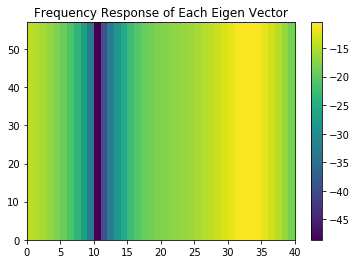

In [69]:
# Plotting eigen vector's frequency response
ev_freqresp = np.abs(np.transpose(fqall))
fig_ev, ax_ev = mpl.subplots()
ax1 = ax_ev.imshow(mag2db(ev_freqresp), extent = [0, 40, 0, 57], aspect='auto')
fig_ev.colorbar(ax1)
ax_ev.set_title('Frequency Response of Each Eigen Vector')